# Comprehensive Feature Predictive Power Analysis and Selection

**Project Summary:** 

This notebook provides a comprehensive evaluation of feature predictive power (in this example for fraud detection models) by integrating exploratory data analysis, advanced statistical metrics, and machine learning techniques. The analysis is structured into seven sections, each contributing key insights into feature performance:

- **EDA and Feature Overview:**  
  Summarizes each feature's characteristics including type, missing values, cardinality, and detailed descriptive statistics for numeric features (with outlier detection). Categorical features are preserved in their raw form for summary purposes and then transformed for visual and predictive analysis.

- **Visual Distribution and Relationship Plots:**  
  Uses histograms or bar plots to display feature distributions, boxplots to show the relationship between features and the fraud target, and binned fraud rate charts to reveal how fraud rates vary across feature intervals.

- **Advanced Performance Visualizations:**  
  Provides PSI plots to assess distribution stability between datasets, lift charts to evaluate segmentation power, and PR-AUC curves along with key classification metrics (Precision, Recall, F1 Score) to measure predictive performance.

- **WOE and IV Analysis:**  
  Breaks down features into bins and calculates Weight of Evidence (WOE) and Information Value (IV) to quantify how well each feature distinguishes between fraudulent and non-fraudulent cases. Scaled IV values are computed to facilitate direct comparisons across features.

- **Extra Categorical Metrics:**  
  Augments the analysis with additional metrics such as Chi-Square P-Value, Cramér’s V, Mutual Information, Gini Index, ReliefF Score, and Information Gain, further supporting the evaluation of categorical feature performance.

- **Feature Correlations Analysis:**  
  Examines the correlation matrix to identify and flag highly correlated features (with near-perfect correlations) as candidates for removal, helping to mitigate multicollinearity and streamline the feature set.

- **Combined Feature Importance Analysis using LightGBM and SHAP:**  
  Executes multiple runs of a LightGBM classifier on the training data and employs SHAP values to rank features based on their predictive contribution. The aggregated, scaled SHAP values provide actionable insights into which features are most influential for detecting fraud.


This notebook systematically combines statistical summaries, visualization techniques, and model-based metrics to determine the most effective features for fraud detection in card transactions. By evaluating features comprehensively—from data quality and distribution stability to their direct influence on predictive performance—the analysis ensures the final selected features form a robust, accurate, and reliable foundation for high-performing fraud detection models and rule development.


- *Note: Example outputs are provided in each section to illustrate the expected results.
- *Note: This specific notebook is based on fraud detection for card transaction data. 

# Imports and Connections

In [0]:
# Imports

# IPython magics (cell magic commands)
%autosave 10
%pylab inline
%matplotlib inline

# Standard library imports
import contextlib
import io
import logging
import math
import time
import warnings
import builtins

# Configure logging and warnings
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# Third-party libraries for data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    average_precision_score, roc_auc_score, precision_recall_curve
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

# SciPy libraries
from scipy.stats import chi2_contingency, fisher_exact

# LightGBM and SHAP libraries
import lightgbm as lgb
import shap

# IPython display
from IPython.display import display


# Prerequisites:
- A training DataFrame named 'train_df' and a that contains:
    * A target column (e.g. 'TARGET')
    * All feature columns specified in the list 'feature_list'.
- A test DataFrame named 'test_df' that has the same feature columns as 'train_df' (used for PSI calculation).
- A list of features to analyze named 'feature_list' (e.g. feature_list = ['Age', 'Income', 'Gender', 'CreditScore')

In [19]:
# Define the feature list (populate with desired column names for analysis)
feature_list = []

# Load training and test datasets from CSV files
train_df = pd.read_csv('Train_DF.csv')
test_df = pd.read_csv('Test_DF.csv')

Feature List: ['Freq_at_Merchant', '24_Hr_Card_Use_Freq', '24_Hr_Card_Sum', 'Historical_Transactions_at_Merchant', 'Historical_Transactions_in_State', 'Merchant_State']

Training Data: train_df

Testing Data: test_df


# Guide to Interpreting the Analysis Outputs

This notebook provides a comprehensive analysis of each feature's predictive power for fraud detection using several statistical and visualization techniques. Below is a step-by-step guide to understanding the rationale behind each section of the analysis and how to interpret the key outputs.

---

## 1. EDA (Exploratory Data Analysis)

### Summary Statistics & Feature Overview
- **Output:** A table summarizing key properties of the feature such as:
  - **Feature Name and Type:** Indicates whether the feature is numeric or categorical.
  - **Missing Values (%):** The proportion of missing data.
  - **Unique Values & Cardinality:** The number of distinct values, classified as:
    - **Low Cardinality:** Fewer than 10 unique values.
    - **Moderate Cardinality:** Between 10 and 49 unique values.
    - **High Cardinality:** 50 or more unique values.
  - **For Numeric Features:** Additional descriptive statistics (Mean, Std, Min, Quartiles, Max) and outlier information (using a 3×IQR rule).

- **Handling Categorical Variables:**  
  - **Preservation of Raw Data:** The original categorical values (e.g., hundreds of zip codes) are preserved to compute summary metrics such as missing value percentage and unique counts.
  - **Transformation for Analysis:** For visualizations and IV/PSI calculations, the data is transformed by:
    - **Merging Rare Levels:** Categories with counts below a threshold (e.g., < 50) are grouped as "Other."
    - **Limiting the Number of Groups:** If more than a set limit (e.g., 10) remain, only the most frequent categories are retained while the rest are combined as "Other."  
  This ensures that the metrics (e.g., Total IV) and plots are clear and comparable across both numeric and categorical features.

---

## 2. Visual Plots (First Row): Histogram, Boxplot, Binned Fraud Rate Chart

Three plots are generated to visualize the feature's distribution and its relationship with fraud:

- **Histogram / Bar Plot:**
  - **Numeric Features:** Displays the distribution (with transformations applied to reduce skewness).
  - **Categorical Features:** Displays counts per transformed category (after merging rare levels and limiting the number of groups) so that the plot remains uncluttered while the original unique count is still preserved in the summary.

- **Boxplot:**
  - Plots the feature values against the binary fraud indicator (0 = Non-Fraud, 1 = Fraud) to reveal differences in distribution and potential outliers.

- **Binned Fraud Rate Chart:**
  - Divides the feature into bins (quantile-based for numeric features or using the transformed categorical groups) and shows:
    - **Count:** Number of observations in each bin.
    - **Fraud Rate:** Proportion of fraud cases in each bin.
  - **Interpretation:**  
    - A steadily rising fraud rate across bins indicates strong discriminative power.
    - Flat or inconsistent fraud rates may suggest that the feature is less effective at separating classes.

---

## 3. Visual Plots (Second Row): PSI, Lift, and PR-AUC

This section provides additional visualizations to assess predictive performance:

### PSI Plot
- **What It Shows:**  
  - A bar chart of the Population Stability Index (PSI) for each bin.
- **For Categorical Features:**  
  - The same condensation logic (merging rare categories and capping group numbers) is applied to both training and test data, ensuring consistent and readable PSI plots.
- **Interpretation:**  
  - **Stable (Total PSI < 0.1):** Little change between datasets.
  - **Moderate Change (Total PSI between 0.1 and 0.25):** Some shifts observed.
  - **Unstable (Total PSI > 0.25):** Significant shifts that might affect model stability.

### Lift Chart
- **X-axis:**  
  - For numeric features, deciles are determined by quantile splits (using `pd.qcut`).  
  - For categorical features, the lift chart uses the same ordered groups (as defined by frequency order after condensation) as the bar plot and fraud rate chart.
- **Y-axis:**  
  - The ratio of the fraud rate in each group (or decile) to the overall fraud rate.
- **Interpretation:**  
  - **High Lift in Top Groups/Deciles:** Indicates effective segmentation.
  - **Trend:** A descending lift across groups/deciles confirms decreasing fraud risk.
- **Key Predictive Criteria:**
  - **Max Lift < 1.1:** Not predictive.
  - **1.1 ≤ Max Lift < 1.3:** Weak predictive power.
  - **1.3 ≤ Max Lift < 1.6:** Medium predictive power.
  - **Max Lift ≥ 1.6:** Strong predictive power.

### PR-AUC Curve & Classification Metrics
- **Risk Score Calculation:**
  - **Numeric Features:** Values are scaled (using MinMax scaling) and, if needed, inverted so that higher scores indicate higher risk.
  - **Categorical Features:** The transformed groups are mapped to their fraud rates.
- **Metrics Shown:**
  - **PR-AUC Curve:** Illustrates the trade-off between precision and recall.
  - **Classification Metrics:** Include Precision, Recall, and F1 Score (computed at a threshold of 0.5 on the risk score).
- **Interpretation:**
  - **PR-AUC:** A higher area under the curve indicates better performance.
  - **Precision & Recall:** Measure the correctness and completeness of fraud detection.
  - **F1 Score:** Balances precision and recall.

---

## 4. WOE (Weight of Evidence) and IV (Information Value) Table

### Usage:
- **Display:** A table breaking down each bin (from the transformed feature) showing the Weight of Evidence (WOE) and Information Value (IV), along with a Total IV value.
- **Purpose:**  
  - Assists in feature selection by quantifying the ability of a feature to distinguish between fraudulent and non-fraudulent cases.

### Weight of Evidence (WOE)
- **Definition:**  
  - WOE quantifies the separation between the distribution of non-fraud (non-events) and fraud (events) in each bin:
    $$
    \text{WOE} = \ln\left(\frac{\% \text{ of non-events in the bin}}{\% \text{ of events in the bin}}\right)
    $$
- **Interpretation:**  
  - **Positive WOE:** Indicates a higher proportion of non-fraud cases.
  - **Negative WOE:** Indicates a higher proportion of fraud cases.

### Information Value (IV)
- **Definition:**  
  - IV aggregates the differences across bins, weighted by their WOE:
    $$
    \text{IV} = \sum \left( \% \text{ non-events} - \% \text{ events} \right) \times \text{WOE}
    $$
- **Interpretation Guidelines:**
  - **IV < 0.02:** Not predictive.
  - **0.02 ≤ IV < 0.1:** Weak predictive power.
  - **0.1 ≤ IV < 0.3:** Medium predictive power.
  - **IV ≥ 0.3:** Strong predictive power.

- **Binning Differences & Comparability:**  
  - **Numeric Features:** Typically use fixed deciles (10 bins).  
  - **Categorical Features:** May result in fewer or more bins (e.g., 4–10) based on the natural grouping after transformation.
  - **Implication:** Although Total IV is computed by summing the IV across bins, differences in the number of bins can affect its magnitude. To facilitate direct comparison, a **Scaled Total IV** is computed (using MinMax scaling) and included in the final metrics table. This standardizes the IV values onto a 0–1 range, making them comparable regardless of the underlying binning process.

---

## 5. Extra Categorical Metrics

For all features—especially categorical ones—the following additional metrics are computed:

- **Chi-Square P-Value:**  
  - **Lower is Better:** A p-value (typically < 0.05) suggests a significant relationship between the feature and the target.
- **Cramér’s V:**  
  - **Higher is Better:** Values closer to 1 indicate a stronger association; values > 0.3 are considered strong.
- **Mutual Information:**  
  - **Higher is Better:** Indicates more shared information between the feature and the target; values > 0.07 suggest high information gain.
- **Gini Index:**  
  - **Higher is Better:** Reflects greater diversity and discriminative power; values > 0.2 are favorable.
- **ReliefF Score:**  
  - **Higher is Better:** Shows strong ability to distinguish between classes based on nearest neighbors; values > 0.2 are desirable.
- **Information Gain:**  
  - **Higher is Better:** Indicates the feature's effectiveness in reducing uncertainty about the target; values > 0.07 are desirable.

---

### In Summary

- **Preservation & Transformation:**  
  Categorical features are preserved in their raw form for summary statistics but are transformed (by merging rare categories and capping the number of groups) for analysis and visualization. This approach keeps plots readable and metrics comparable.

- **Consistent Application:**  
  The same transformation logic is applied to both training and test datasets. This ensures that metrics such as Total IV and PSI, and plots (bar, fraud rate, and lift charts), are computed consistently across numeric and categorical features.

- **Binning & IV Interpretation:**  
  - **Numeric Features:** Use fixed deciles, leading to a uniform number of bins.  
  - **Categorical Features:** The number of bins depends on the transformed grouping.
  - **Total IV** aggregates IV values from all bins. Differences in bin count affect the absolute value of Total IV.

- **Scaled Total IV:**  
  To directly compare the predictive power across features regardless of bin count, Total IV is standardized (scaled to a 0–1 range) and reported as **Scaled Total IV**. This relative metric facilitates direct comparison even when the underlying binning processes differ.

Overall, while the underlying binning process may vary between numeric and categorical features, the standardized (scaled) metrics provide a common ground for comparing predictive power.


Feature Name: Freq_at_Merchant

EDA Analysis:


,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound,Mean,Std,Min,25%,50%,75%,Max
0,Freq_at_Merchant,numeric,43.12%,279,High,0,0.00%,-1.4,2.8,0.680346,0.352527,0.0,0.4,0.833333,1.0,1.0


Visual Plots:


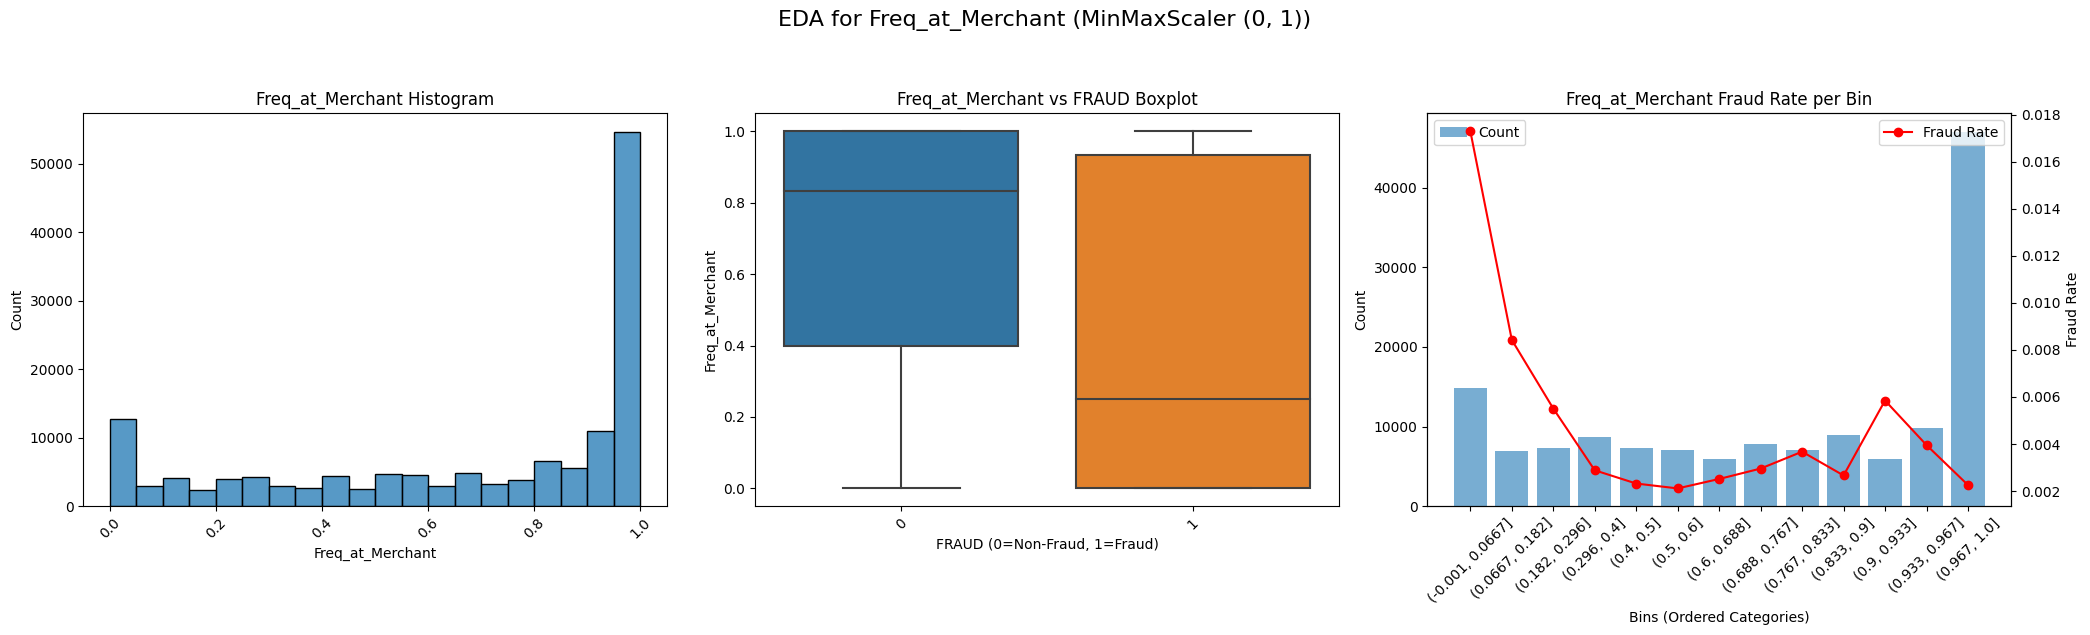

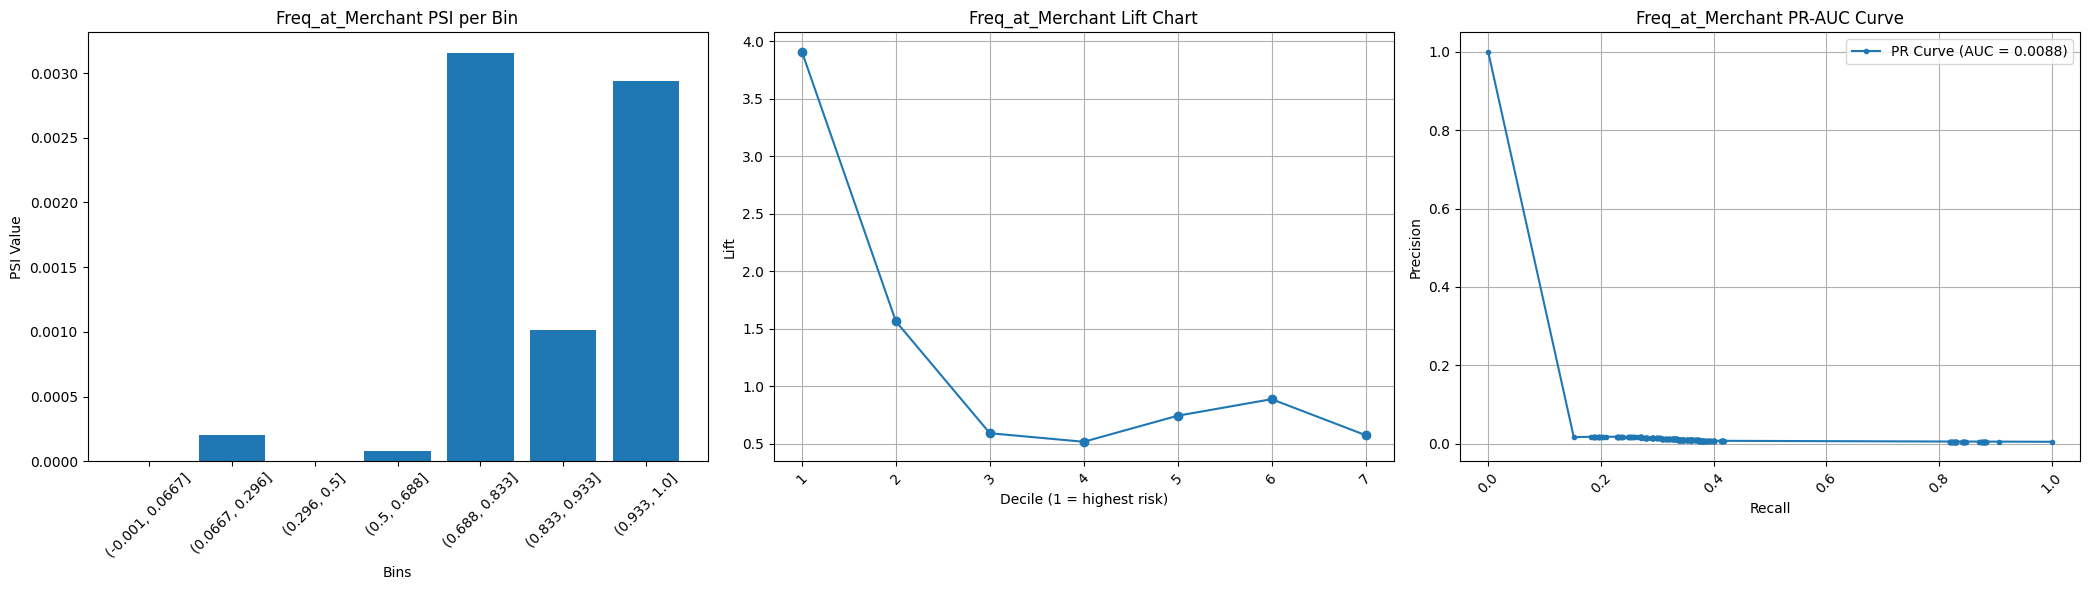


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,"(-0.001, 0.0667]",14604,257,5.765245,22.824156,-1.3760,0.2347
1,"(0.0667, 0.296]",14048,98,5.545752,8.703375,-0.4507,0.0142
2,"(0.296, 0.5]",15949,42,6.296213,3.730018,0.5235,0.0134
3,"(0.5, 0.688]",13028,30,5.143085,2.664298,0.6577,0.0163
4,"(0.688, 0.833]",14803,49,5.843805,4.351687,0.2948,0.0044
5,"(0.833, 0.933]",14931,59,5.894335,5.239787,0.1177,0.0008
6,"(0.933, 1.0]",56676,145,22.374078,12.877442,0.5524,0.0525
7,Total,144039,680,NaN,NaN,NaN,0.3363



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,Freq_at_Merchant,numeric,43.12%,273,0.3363,NaN,0.007399,3.907752,0.008823,0.352575,0.017214,0.008811,5.398850e-60,0.299236,0.049258,0.785712,0.006884,0.071064



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound,Mean,Std,Min,25%,50%,75%,Max
0,24_Hr_Card_Use_Freq,numeric,0.00%,112,High,2415,0.95%,-3.0,4.0,0.735903,4.009637,0.0,0.0,0.0,1.0,127.0


Visual Plots:


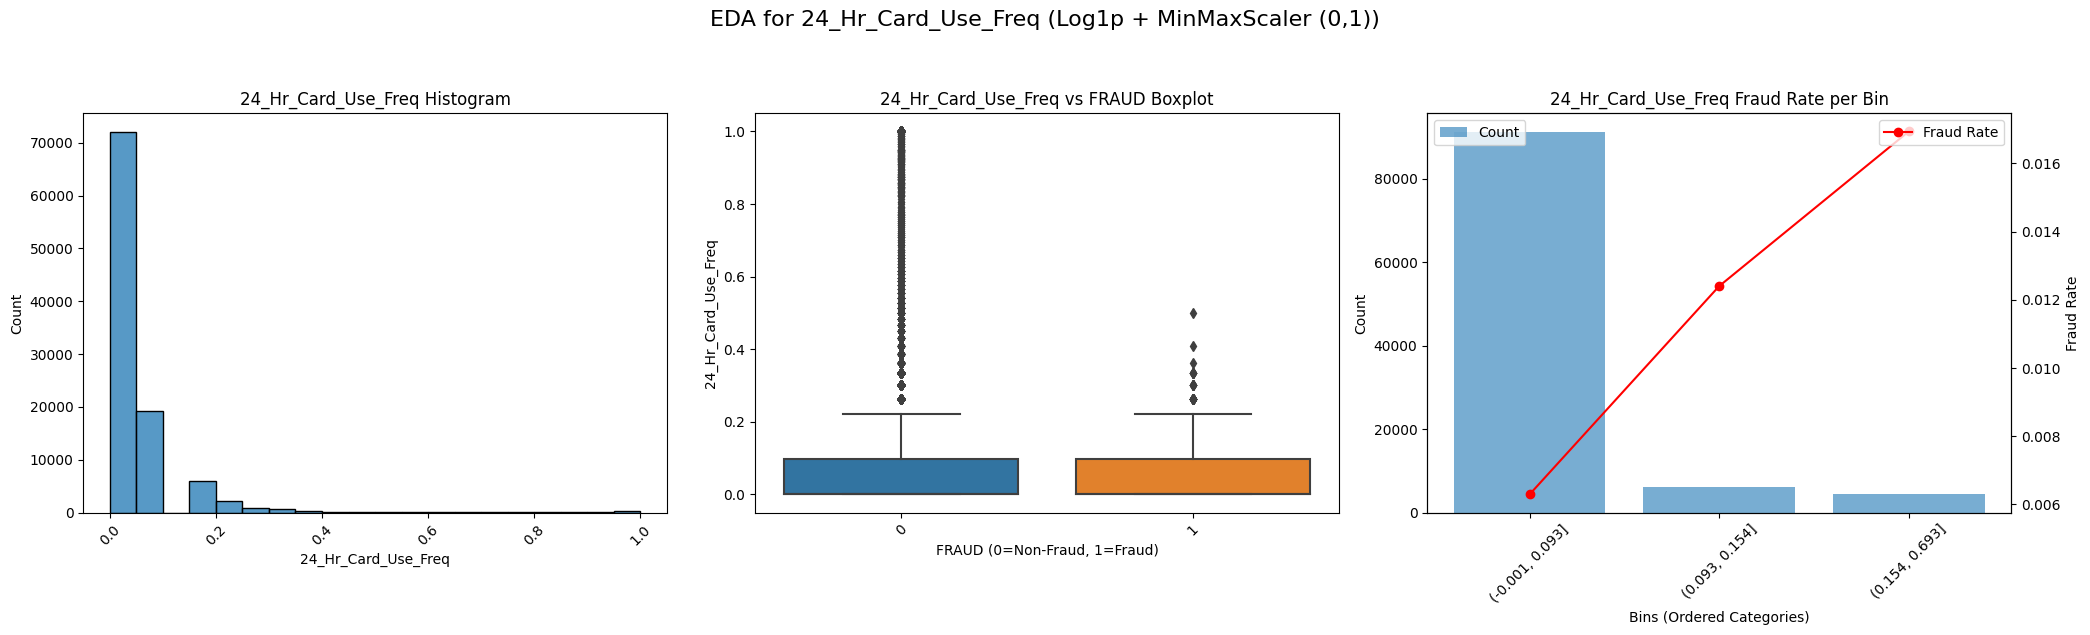

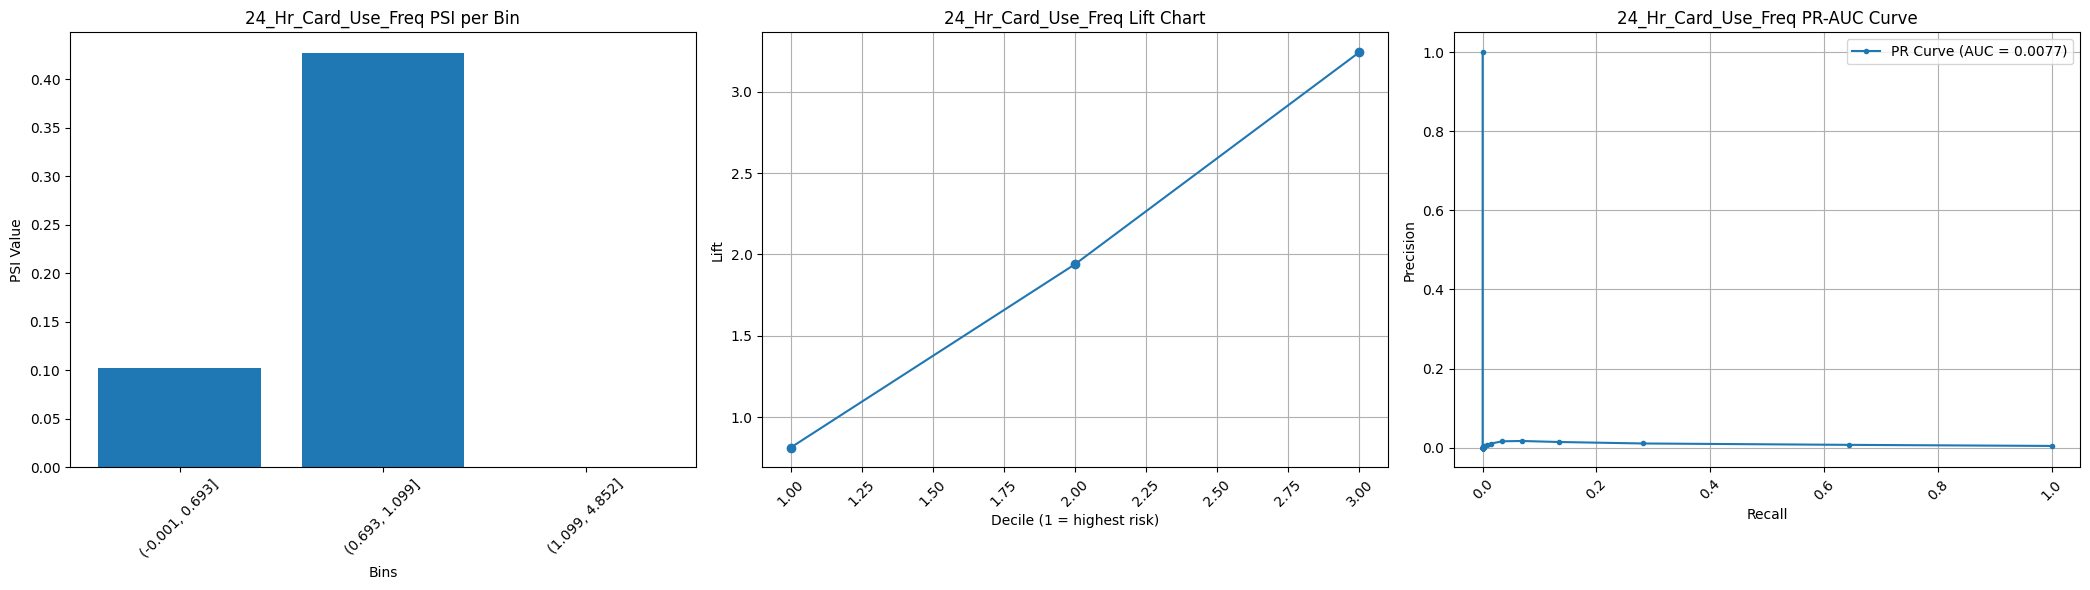


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,"(-0.001, 0.693]",223817,809,88.356605,71.847247,0.2068,0.0341
1,"(0.693, 1.099]",19053,165,7.521584,14.653641,-0.6669,0.0476
2,"(1.099, 4.852]",10441,152,4.121811,13.499112,-1.1863,0.1112
3,Total,253311,1126,NaN,NaN,NaN,0.1929



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,24_Hr_Card_Use_Freq,numeric,0.00%,21,0.1929,NaN,0.529657,3.242399,0.0,0.0,0.0,0.007691,8.647812e-107,0.24457,0.030892,0.633512,0.000986,0.044568



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound,Mean,Std,Min,25%,50%,75%,Max
0,24_Hr_Card_Sum,numeric,0.00%,47842,High,3508,1.38%,-534.39,712.52,121.370213,120417.619075,-21474836.47,0.0,0.0,178.13,21474836.47


Visual Plots:


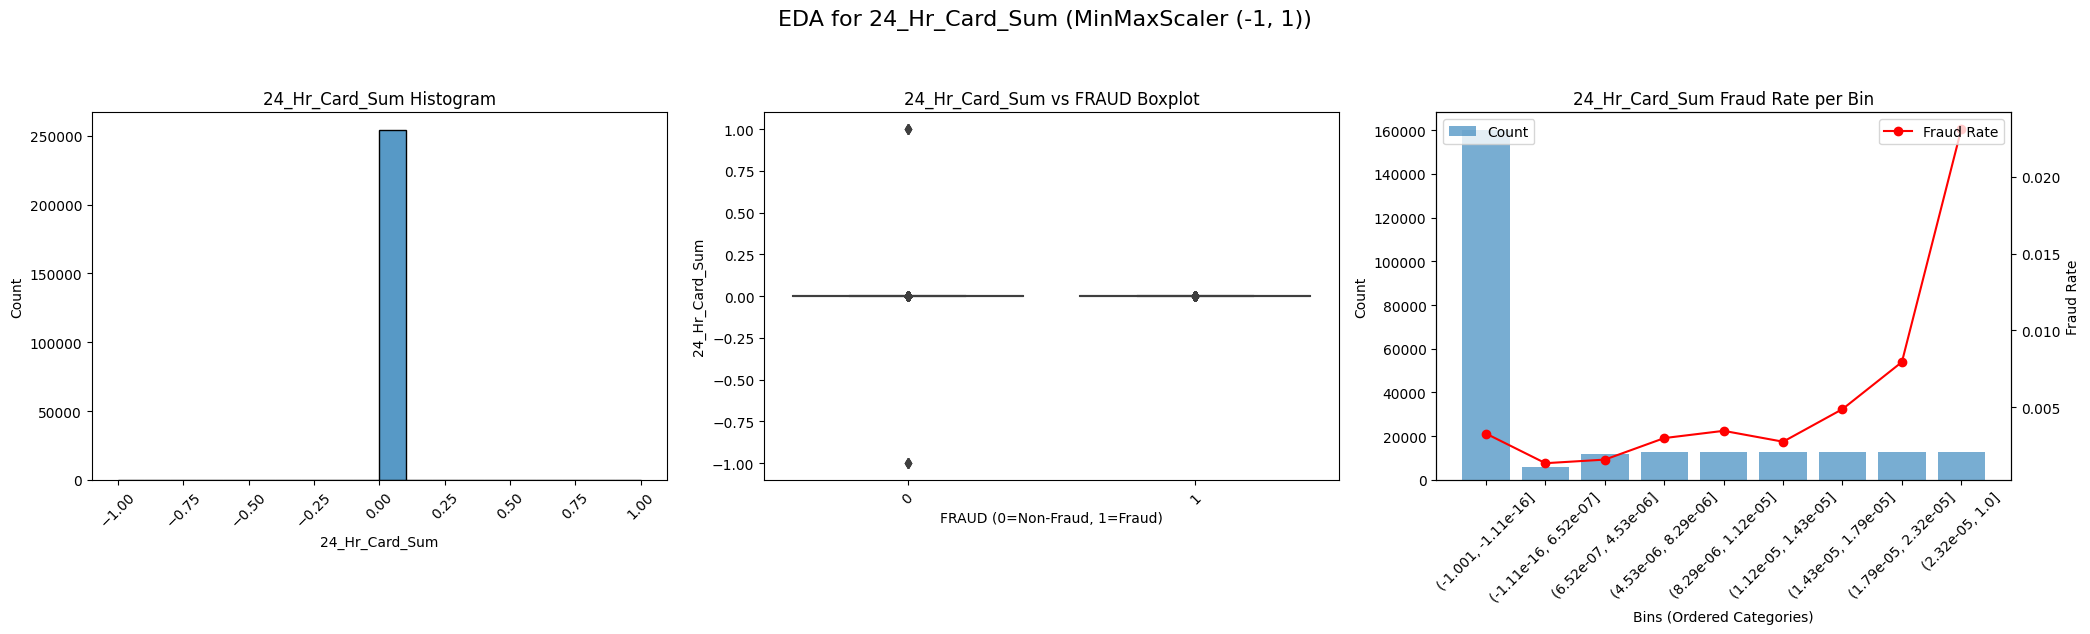

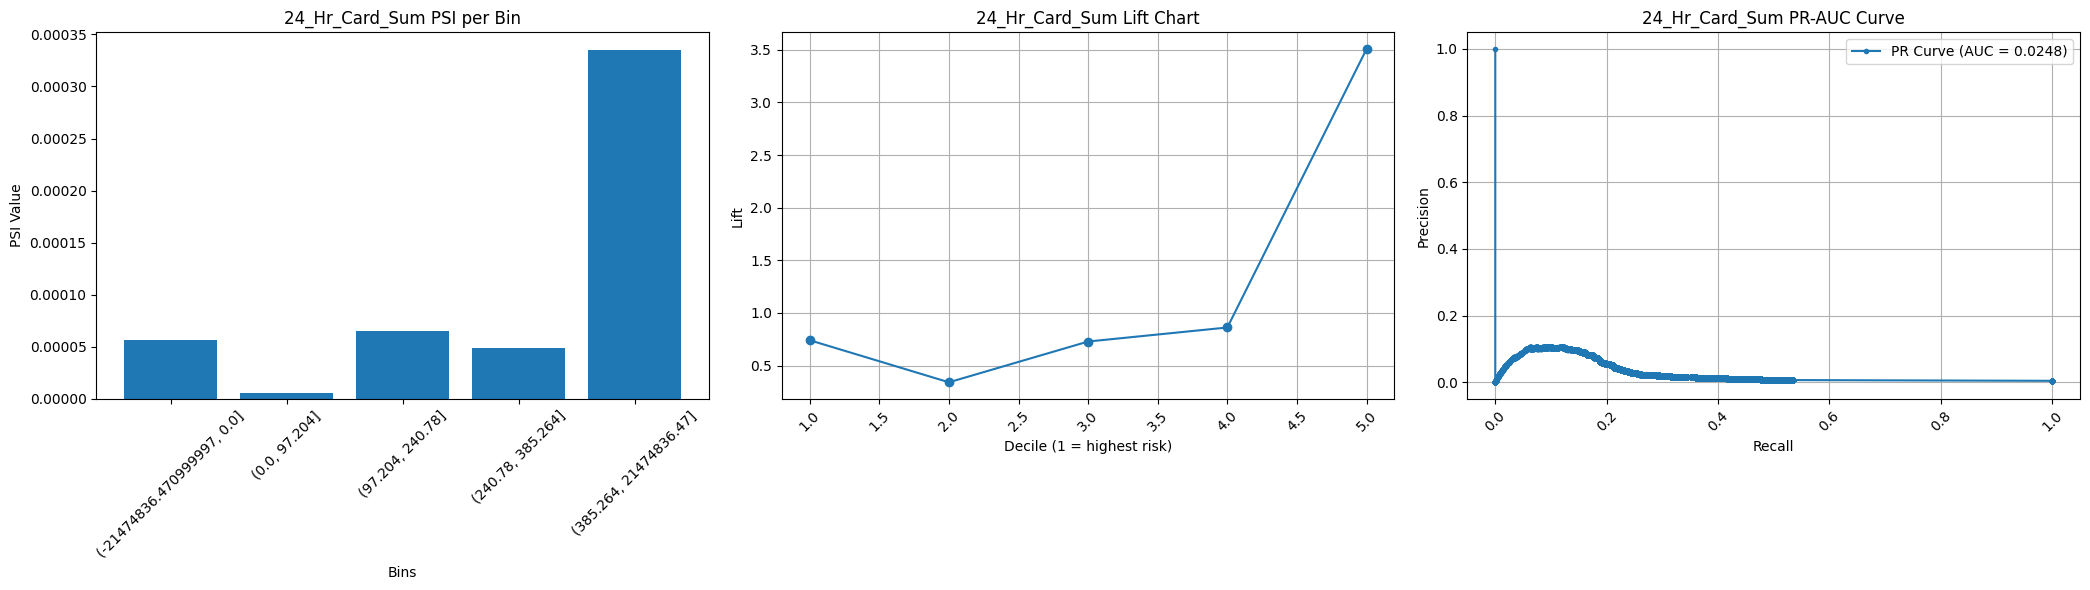


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,"(-21474836.470999997, 0.0]",159674,525,63.034768,46.625222,0.3015,0.0495
1,"(0.0, 97.204]",17880,27,7.058517,2.397869,1.0797,0.0503
2,"(97.204, 240.78]",25362,82,10.012198,7.282416,0.3183,0.0087
3,"(240.78, 385.264]",25346,97,10.005882,8.614565,0.1497,0.0021
4,"(385.264, 21474836.47]",25049,395,9.888635,35.079929,-1.2662,0.3190
5,Total,253311,1126,NaN,NaN,NaN,0.4296



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,24_Hr_Card_Sum,numeric,0.00%,3726,0.4296,NaN,0.000513,3.507952,0.006377,0.533748,0.012604,0.024772,0.000002,0.662143,0.298331,0.679136,0.007834,0.430401



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound,Mean,Std,Min,25%,50%,75%,Max
0,Historical_Transactions_at_Merchant,numeric,0.00%,128,High,22820,8.97%,-39.0,52.0,14.083628,27.916944,0.0,0.0,2.0,13.0,127.0


Visual Plots:


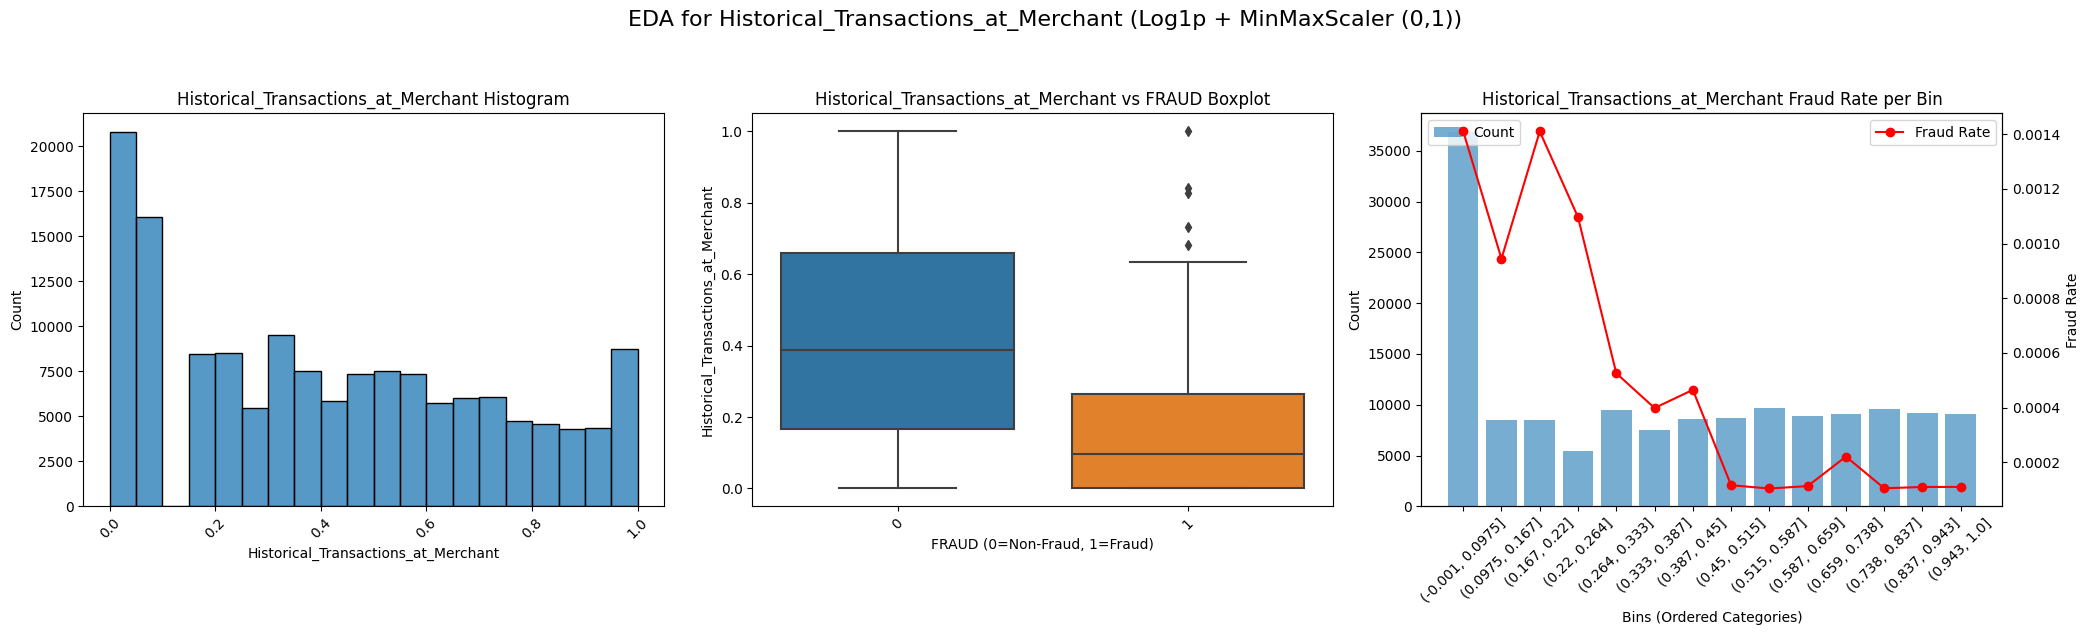

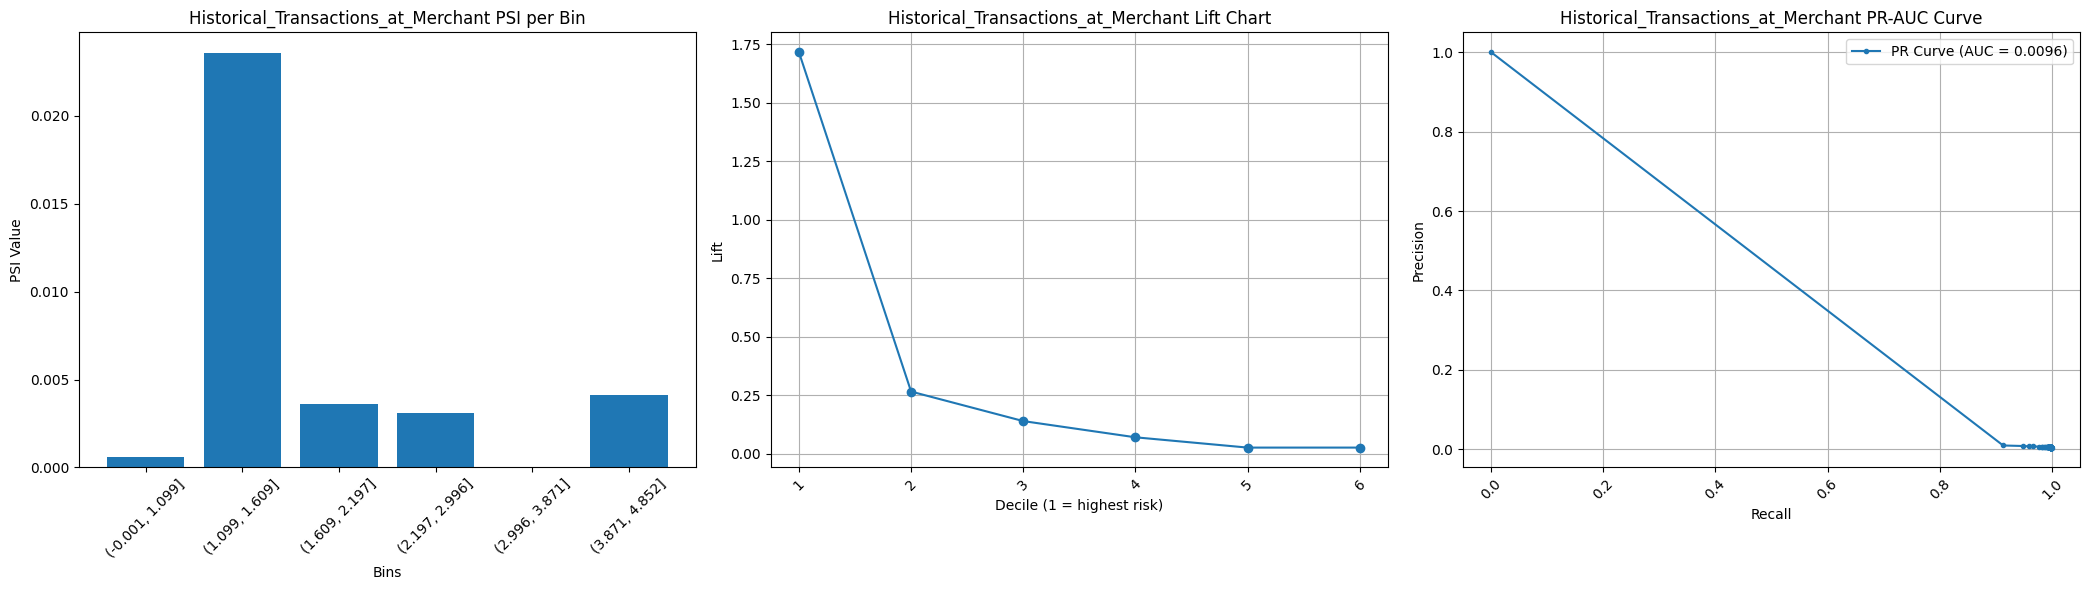


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,"(-0.001, 1.099]",141135,1080,55.716096,95.914742,-0.5432,0.2184
1,"(1.099, 1.609]",16957,20,6.694143,1.776199,1.3268,0.0652
2,"(1.609, 2.197]",19345,12,7.636857,1.065719,1.9693,0.1294
3,"(2.197, 2.996]",25511,8,10.071019,0.710480,2.6515,0.2482
4,"(2.996, 3.871]",25200,3,9.948245,0.266430,3.6200,0.3505
5,"(3.871, 4.852]",25163,3,9.933639,0.266430,3.6186,0.3498
6,Total,253311,1126,NaN,NaN,NaN,1.3615



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,Historical_Transactions_at_Merchant,numeric,0.00%,126,1.3615,NaN,0.03507,1.716012,0.004767,0.998224,0.009489,0.009551,0.0,0.476961,0.132021,0.602675,0.019088,0.190466



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound,Mean,Std,Min,25%,50%,75%,Max
0,Historical_Transactions_in_State,numeric,0.00%,128,High,19842,7.80%,-30.0,40.0,10.166851,20.035012,0.0,0.0,1.0,10.0,127.0


Visual Plots:


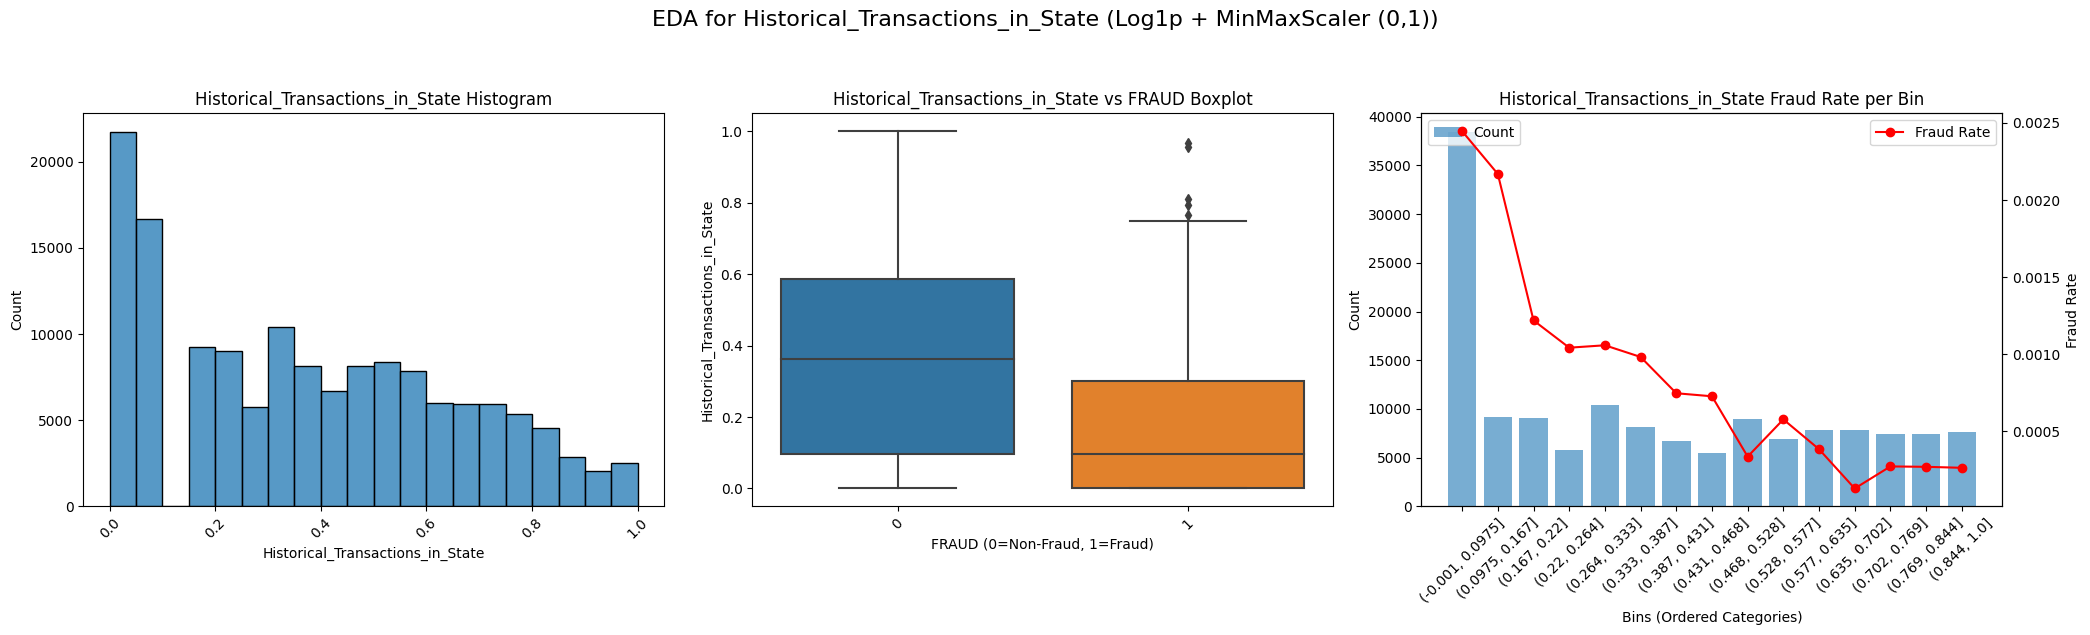

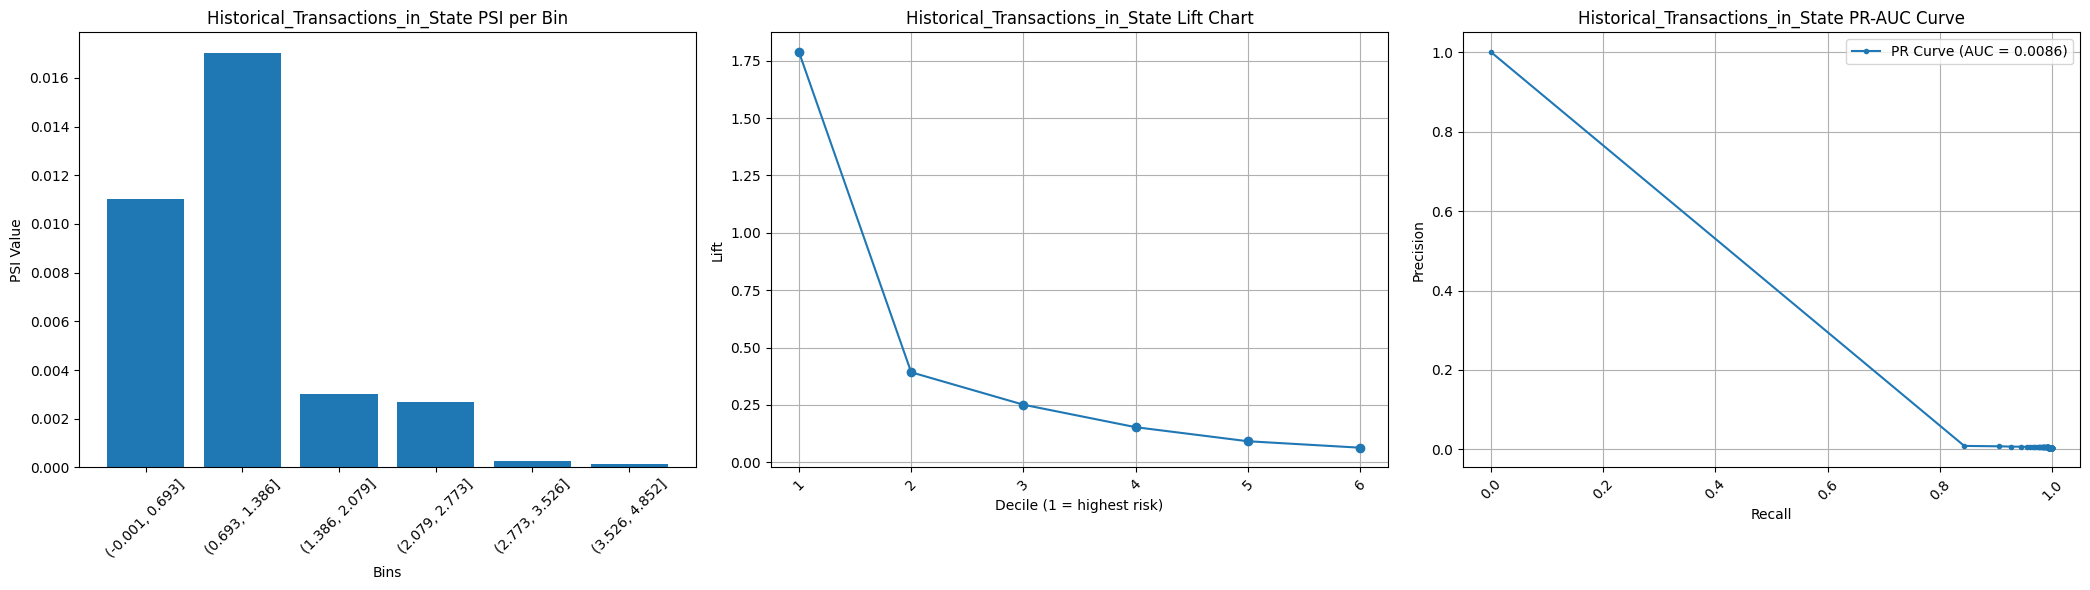


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,"(-0.001, 0.693]",127801,1019,50.452211,90.497336,-0.5843,0.2340
1,"(0.693, 1.386]",25871,45,10.213137,3.996448,0.9383,0.0583
2,"(1.386, 2.079]",25171,28,9.936797,2.486679,1.3853,0.1032
3,"(2.079, 2.773]",25066,17,9.895346,1.509769,1.8801,0.1577
4,"(2.773, 3.526]",24593,10,9.708619,0.888099,2.3917,0.2110
5,"(3.526, 4.852]",24809,7,9.793890,0.621670,2.7571,0.2529
6,Total,253311,1126,NaN,NaN,NaN,1.0171



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,Historical_Transactions_in_State,numeric,0.00%,117,1.0171,NaN,0.034176,1.787445,0.00457,0.998224,0.009099,0.008571,5.871874e-266,0.416006,0.097161,0.622846,0.009236,0.140173



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

,Feature Name,Feature Type,Missing Values (%),Unique Values,Cardinality,Outliers Count,Outliers (%),Outliers Lower Bound,Outliers Upper Bound
0,Merchant_State,categorical,0.00%,55,High,N/A,N/A,N/A,N/A


Visual Plots:


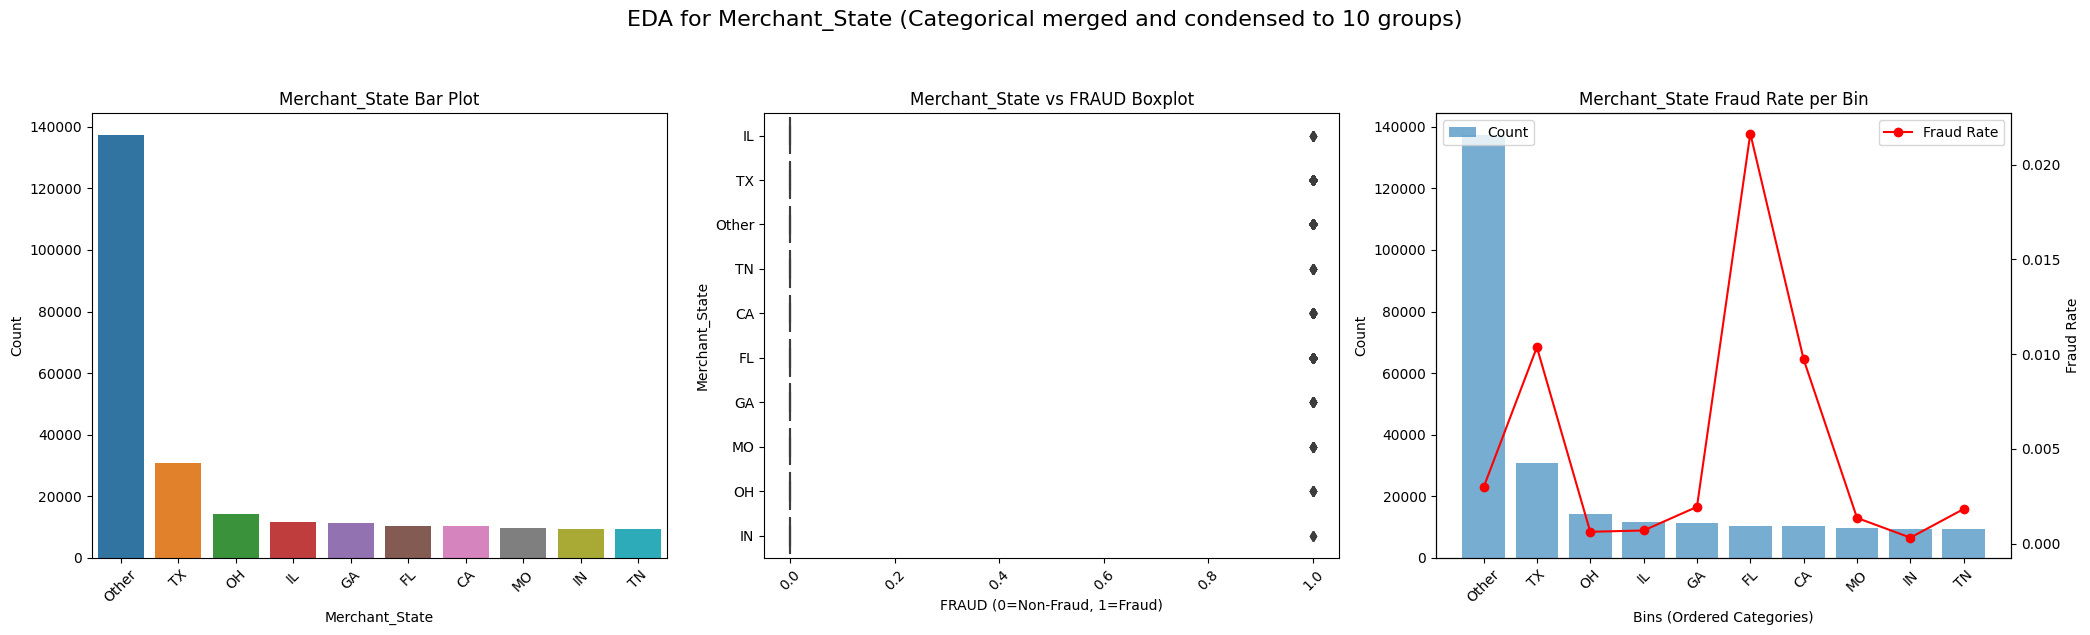

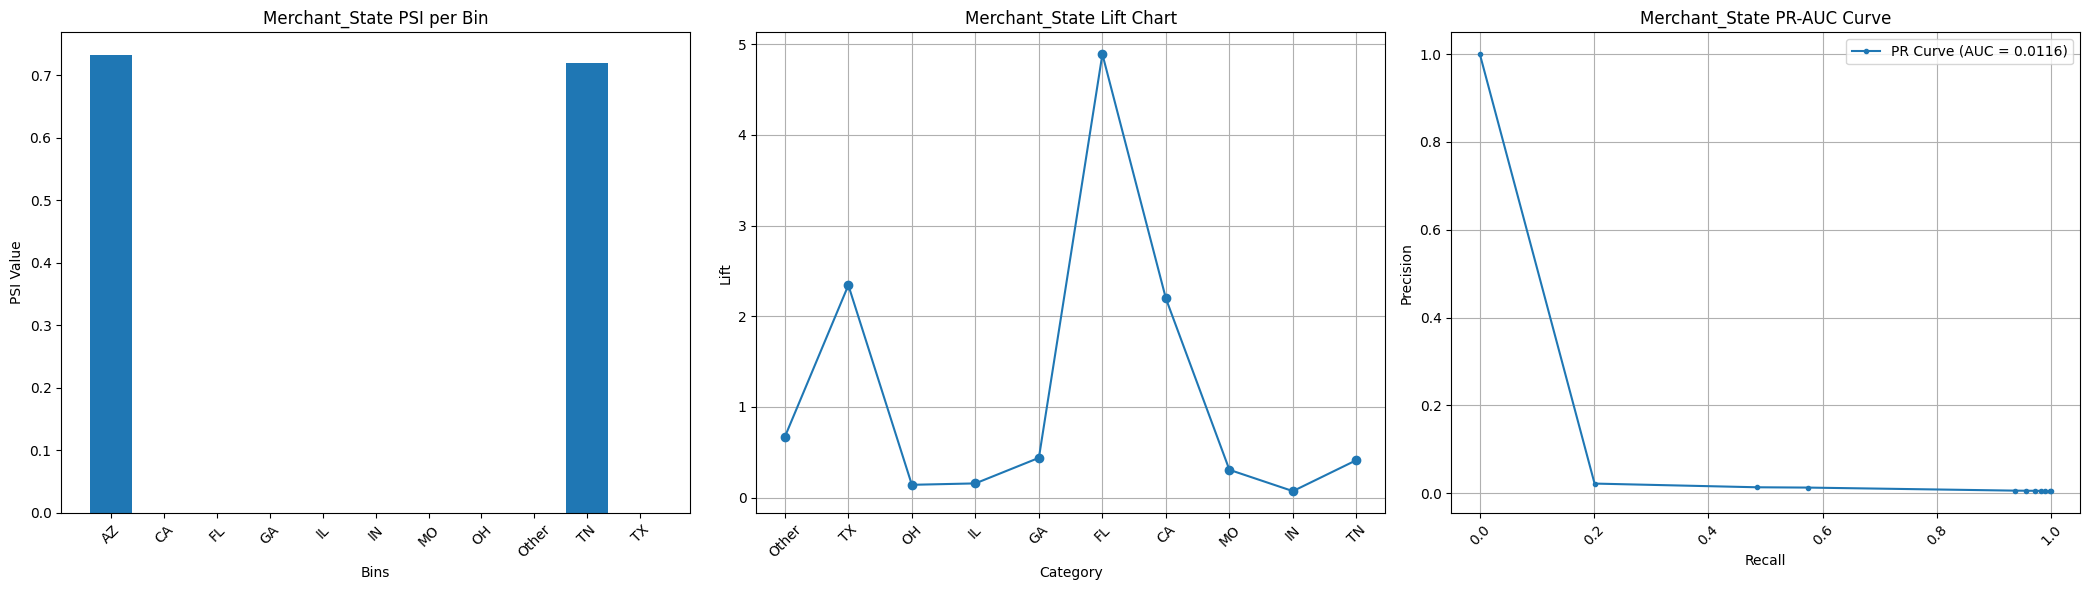


WOE / IV Table:


,Bin,Count Non-Events,Count Events,% of Non-Events,% of Events,WOE,IV
0,CA,10190,100,4.022723,8.880995,-0.7920,0.0385
1,FL,10219,226,4.034171,20.071048,-1.6045,0.2573
2,GA,11298,22,4.460130,1.953819,0.8254,0.0207
3,IL,11470,8,4.528031,0.710480,1.8521,0.0707
4,IN,9376,3,3.701379,0.266430,2.6313,0.0904
5,MO,9549,13,3.769674,1.154529,1.1833,0.0309
6,OH,14307,9,5.647998,0.799290,1.9553,0.0948
7,Other,137088,408,54.118455,36.234458,0.4012,0.0717
8,TN,9262,17,3.656375,1.509769,0.8845,0.0190
9,TX,30552,320,12.061063,28.419183,-0.8571,0.1402



Final Combined Metrics:


,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
0,Merchant_State,categorical,0.00%,52,0.8342,NaN,1.451299,4.889246,0.0,0.0,0.0,0.011554,0.0,0.478919,0.125185,0.937083,0.010276,0.180604



------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


--------------------------------

In [32]:
# Code

def improved_numeric_binning(feature_series, target_series, q_bins=10):
    """
    Applies an improved binning strategy for numeric features:
      - If the feature is highly skewed (skewness > 1) and non-negative, apply a log1p transformation.
      - Uses quantile-based binning (pd.qcut) to create balanced bins.
      - Iteratively reduces the number of bins until each bin contains at least one fraud and one non-fraud case.
      
    Returns:
      balanced_bins: A pd.Categorical series of bin assignments (aligned with feature_series.dropna()).
      transformed_series: The transformed series (log1p applied if conditions met; otherwise original).
    """
    series = feature_series.copy()
    if not series.dropna().empty:
        skewness = series.dropna().skew()
    else:
        skewness = 0
    if skewness > 1 and (series.dropna() >= 0).all():
        series = np.log1p(series)
    q = q_bins
    balanced_bins = None
    while q >= 2:
        try:
            bins = pd.qcut(series.dropna(), q=q, duplicates='drop')
        except ValueError:
            q -= 1
            continue
        bin_categories = bins.cat.categories
        balanced = True
        for cat in bin_categories:
            idx = bins.index[bins == cat]
            if target_series.loc[idx].nunique() < 2:
                balanced = False
                break
        if balanced:
            balanced_bins = bins
            break
        else:
            q -= 1
    if balanced_bins is None:
        balanced_bins = pd.qcut(series.dropna(), q=2, duplicates='drop')
    return balanced_bins, series

def analyze_single_feature_woe_iv(df, feature_name, target_name='TARGET', test_df=None):
    """
    Analyzes a single feature for its predictive power for fraud detection.
    Fraud is defined as target in [1]. This function:
      • Computes summary statistics and EDA metrics.
      • Displays two rows of plots:
          - First row: Histogram/Bar, Boxplot, and Binned Fraud Rate (3 plots)
          - Second row: PSI plot, Lift chart, and PR‑AUC curve (3 plots)
      • Calculates a WOE/IV table.
      
    Returns:
      woe_iv_table, total_iv, total_psi, max_lift, pr_auc_value, precision, recall, f1, summary_df
    """
    df = df.copy()
    df['target_bin'] = df[target_name].apply(lambda x: 1 if x in [1] else 0)
    orig_feature_data = df[feature_name].copy()
    feature_data = df[feature_name]
    target_data = df['target_bin']
    feature_type = 'numeric' if pd.api.types.is_numeric_dtype(feature_data) else 'categorical'
    missing_count = orig_feature_data.isna().sum()
    unique_count = orig_feature_data.nunique()
    if feature_type == 'numeric':
        stats = orig_feature_data.describe()
        q1, q3 = orig_feature_data.quantile(0.25), orig_feature_data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 3 * iqr
        upper_bound = q3 + 3 * iqr
        outliers = df[(feature_data < lower_bound) | (feature_data > upper_bound)]
        num_outliers = outliers.shape[0]
        pct_outliers = num_outliers / df.shape[0] * 100
    else:
        stats = None
        lower_bound = upper_bound = np.nan
        num_outliers = np.nan
        pct_outliers = np.nan
    if unique_count < 10:
        cardinality = "Low"
    elif unique_count < 50:
        cardinality = "Moderate"
    else:
        cardinality = "High"
    summary_dict = {
        "Feature Name": feature_name,
        "Feature Type": feature_type,
        "Missing Values (%)": f"{(missing_count/df.shape[0])*100:.2f}%",
        "Unique Values": unique_count,
        "Cardinality": cardinality,
        "Outliers Count": num_outliers if feature_type=='numeric' else "N/A",
        "Outliers (%)": f"{pct_outliers:.2f}%" if feature_type=='numeric' else "N/A",
        "Outliers Lower Bound": lower_bound if feature_type=='numeric' else "N/A",
        "Outliers Upper Bound": upper_bound if feature_type=='numeric' else "N/A"
    }
    if feature_type == 'numeric':
        summary_dict.update({
            "Mean": stats["mean"],
            "Std": stats["std"],
            "Min": stats["min"],
            "25%": stats["25%"],
            "50%": stats["50%"],
            "75%": stats["75%"],
            "Max": stats["max"]
        })
    summary_df = pd.DataFrame([summary_dict])
    print(f"Feature Name: {feature_name}\n")
    print("EDA Analysis:")
    display(summary_df)
    print("Visual Plots:")
    plot_data = feature_data.copy()
    if feature_type == 'numeric':
        skewness = plot_data.dropna().skew()
        contains_negative = (plot_data.dropna() < 0).any()
        if skewness > 1:
            if contains_negative:
                scaler = MinMaxScaler(feature_range=(-1, 1))
                idx = plot_data.notnull()
                plot_data.loc[idx] = scaler.fit_transform(plot_data[idx].values.reshape(-1, 1)).ravel()
                transform_used = "MinMaxScaler (-1, 1)"
            else:
                plot_data = np.log1p(plot_data.where(plot_data > 0, np.nan))
                scaler = MinMaxScaler(feature_range=(0, 1))
                idx = plot_data.notnull()
                plot_data.loc[idx] = scaler.fit_transform(plot_data[idx].values.reshape(-1, 1)).ravel()
                transform_used = "Log1p + MinMaxScaler (0,1)"
        else:
            scaler = MinMaxScaler(feature_range=(-1, 1) if contains_negative else (0, 1))
            idx = plot_data.notnull()
            plot_data.loc[idx] = scaler.fit_transform(plot_data[idx].values.reshape(-1, 1)).ravel()
            transform_used = f"MinMaxScaler {scaler.feature_range}"
    else:
        feature_data = orig_feature_data.copy()
        thresh = 50
        counts = feature_data.value_counts()
        rare = counts[counts < thresh].index
        feature_data = feature_data.apply(lambda x: "Other" if x in rare else x)
        max_categories = 10
        if feature_data.nunique() > max_categories:
            top_categories = feature_data.value_counts().nlargest(max_categories - 1).index
            feature_data = feature_data.apply(lambda x: x if x in top_categories else "Other")
        df[feature_name] = feature_data
        plot_data = feature_data.copy()
        cnt = plot_data.value_counts(dropna=False)
        cat_order = cnt.index.astype(str)
        transform_used = f"Categorical merged and condensed to {plot_data.nunique()} groups"
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))
    fig.suptitle(f"EDA for {feature_name} ({transform_used})", fontsize=16, y=1.05)
    if feature_type == 'numeric':
        sns.histplot(plot_data.dropna(), bins=20, kde=False, ax=ax[0])
        ax[0].set_title(f"{feature_name} Histogram")
    else:
        sns.barplot(
            x=cat_order,
            y=cnt.values,
            ax=ax[0],
            order=cat_order
        )
        ax[0].set_title(f"{feature_name} Bar Plot")
    ax[0].set_xlabel(feature_name)
    ax[0].set_ylabel("Count")
    ax[0].tick_params(axis='x', rotation=45)
    temp_df = pd.DataFrame({feature_name: plot_data, 'target_bin': target_data})
    sns.boxplot(x='target_bin', y=feature_name, data=temp_df, ax=ax[1])
    ax[1].set_title(f"{feature_name} vs {target_name} Boxplot")
    ax[1].set_xlabel(f"{target_name} (0=Non-Fraud, 1=Fraud)")
    ax[1].set_ylabel(feature_name)
    ax[1].tick_params(axis='x', rotation=45)
    temp_df = temp_df.dropna(subset=[feature_name])
    if feature_type == 'numeric':
        balanced_bins, _ = improved_numeric_binning(temp_df[feature_name], temp_df['target_bin'], q_bins=20)
        temp_df.loc[balanced_bins.index, 'bin'] = balanced_bins
    else:
        temp_df[feature_name] = pd.Categorical(
            temp_df[feature_name],
            categories=cat_order,
            ordered=True
        )
        temp_df['bin'] = temp_df[feature_name].astype('category')
    bin_counts = temp_df['bin'].value_counts(sort=False)
    fraud_rate = temp_df.groupby('bin')['target_bin'].mean()
    ax[2].bar(bin_counts.index.astype(str), bin_counts, alpha=0.6, label='Count')
    ax2 = ax[2].twinx()
    ax2.plot(bin_counts.index.astype(str), fraud_rate, color='red', marker='o', label='Fraud Rate')
    ax[2].set_title(f"{feature_name} Fraud Rate per Bin")
    ax[2].set_xlabel("Bins (Ordered Categories)")
    ax[2].set_ylabel("Count")
    ax2.set_ylabel("Fraud Rate")
    ax[2].legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    total_psi = np.nan
    psi_df = None
    try:
        if pd.api.types.is_numeric_dtype(df[feature_name]):
            train_bins, transformed_train = improved_numeric_binning(df[feature_name], df['target_bin'], q_bins=10)
            if df[feature_name].dropna().skew() > 1 and (df[feature_name].dropna() >= 0).all():
                test_series = np.log1p(test_df[feature_name])
            else:
                test_series = test_df[feature_name]
            test_bins = pd.cut(test_series.dropna(), bins=train_bins.cat.categories, include_lowest=True)
        else:
            train_bins = df[feature_name].astype(str)
            transformed_test = test_df[feature_name].copy()
            thresh = 50
            counts_test = transformed_test.value_counts()
            rare_test = counts_test[counts_test < thresh].index
            transformed_test = transformed_test.apply(lambda x: "Other" if x in rare_test else x)
            max_categories = 10
            if transformed_test.nunique() > max_categories:
                top_categories_test = transformed_test.value_counts().nlargest(max_categories - 1).index
                transformed_test = transformed_test.apply(lambda x: x if x in top_categories_test else "Other")
            test_bins = transformed_test.astype(str)
        baseline = train_bins.value_counts(normalize=True, sort=False)
        monitoring = test_bins.value_counts(normalize=True, sort=False)
        all_bins = baseline.index.union(monitoring.index)
        baseline = baseline.reindex(all_bins, fill_value=0)
        monitoring = monitoring.reindex(all_bins, fill_value=0)
        psi_values = (monitoring - baseline) * np.log((monitoring + 1e-10) / (baseline + 1e-10))
        total_psi = psi_values.sum()
        psi_df = pd.DataFrame({'Bin': psi_values.index.astype(str), 'PSI Value': psi_values.values})
        total_row = pd.DataFrame({'Bin': ['Total'], 'PSI Value': [total_psi]})
        psi_df = pd.concat([psi_df, total_row], ignore_index=True)
    except Exception as e:
        print(f"Error calculating PSI: {e}")
        psi_df = None
        total_psi = np.nan
    if pd.api.types.is_numeric_dtype(df[feature_name]):
        df['decile'] = pd.qcut(df[feature_name].dropna(), q=10, labels=False, duplicates='drop')
        lift_table = df.groupby('decile').agg(response_rate=('target_bin', 'mean')).reset_index()
        x_labels = lift_table['decile'] + 1
        xlabel = "Decile (1 = highest risk)"
    else:
        df[feature_name] = pd.Categorical(df[feature_name], categories=cat_order, ordered=True)
        df['decile'] = df[feature_name]
        lift_table = df.groupby('decile', sort=False).agg(response_rate=('target_bin', 'mean')).reset_index()
        x_labels = lift_table['decile']
        xlabel = "Category"
    overall_rate = df['target_bin'].mean()
    lift_table['lift'] = lift_table['response_rate'] / overall_rate
    max_lift = lift_table['lift'].max()
    lift_value = lift_table['lift'].max()
    threshold = 0.5
    if pd.api.types.is_numeric_dtype(df[feature_name]):
        scaler = MinMaxScaler(feature_range=(0, 1))
        feat_vals = df[feature_name].fillna(df[feature_name].median()).values.reshape(-1, 1)
        risk_score = scaler.fit_transform(feat_vals).ravel()
        if target_data.nunique() > 1 and risk_score[target_data==1].mean() < risk_score[target_data==0].mean():
            risk_score = 1 - risk_score
    else:
        if not pd.api.types.is_categorical_dtype(df[feature_name]):
            df[feature_name] = df[feature_name].fillna("Missing")
        else:
            if "Missing" not in df[feature_name].cat.categories:
                df[feature_name] = df[feature_name].cat.add_categories("Missing")
            df[feature_name] = df[feature_name].fillna("Missing")
        fraud_rate_map = df.groupby(feature_name)['target_bin'].mean()
        risk_score = df[feature_name].map(fraud_rate_map).fillna(overall_rate).values
    pred_bin = (risk_score >= threshold).astype(int)
    pr_auc_value = average_precision_score(target_data, risk_score)
    precision_val = precision_score(target_data, pred_bin, zero_division=0)
    recall_val = recall_score(target_data, pred_bin, zero_division=0)
    f1_val = f1_score(target_data, pred_bin, zero_division=0)
    fig, ax = plt.subplots(1, 3, figsize=(21, 6))
    if psi_df is not None:
        ax[0].bar(psi_df['Bin'][:-1], psi_df['PSI Value'][:-1])
        ax[0].set_xlabel('Bins')
        ax[0].set_ylabel('PSI Value')
        ax[0].set_title(f'{feature_name} PSI per Bin')
        ax[0].tick_params(axis='x', rotation=45)
    else:
        ax[0].text(0.5, 0.5, 'PSI not available', ha='center', va='center')
        ax[0].set_axis_off()
    ax[1].plot(x_labels, lift_table['lift'], marker='o')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel("Lift")
    ax[1].set_title(f"{feature_name} Lift Chart")
    ax[1].grid(True)
    ax[1].tick_params(axis='x', rotation=45)
    import sklearn.metrics as metrics
    pr_prec, pr_rec, _ = precision_recall_curve(target_data, risk_score)
    pr_auc_value = metrics.average_precision_score(target_data, risk_score)
    ax[2].plot(pr_rec, pr_prec, marker='.', label=f'PR Curve (AUC = {pr_auc_value:.4f})')
    ax[2].set_xlabel('Recall')
    ax[2].set_ylabel('Precision')
    ax[2].set_title(f'{feature_name} PR-AUC Curve')
    ax[2].legend()
    ax[2].grid(True)
    ax[2].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    def woe_iv_single_bin(event_count, non_event_count, total_events, total_non_events):
        rate_events = event_count / total_events if total_events else 0
        rate_non_events = non_event_count / total_non_events if total_non_events else 0
        if rate_events == 0 or rate_non_events == 0:
            return 0, 0
        woe_val = np.log(rate_non_events / rate_events)
        iv_val = (rate_non_events - rate_events) * woe_val
        return woe_val, iv_val
    def calculate_woe_iv(feature_series, target_series, bins=10):
        total_events = target_series.sum()
        total_non_events = len(target_series) - total_events
        if pd.api.types.is_numeric_dtype(feature_series):
            balanced_bins, _ = improved_numeric_binning(feature_series, target_series, q_bins=bins)
            binned = balanced_bins
            aligned_target = target_series.loc[binned.index]
        else:
            binned = feature_series.astype('category')
            aligned_target = target_series
        rows = []
        for cat in binned.cat.categories:
            mask = (binned == cat)
            event_count = aligned_target[mask].sum()
            non_event_count = mask.sum() - event_count
            woe_val, iv_val = woe_iv_single_bin(event_count, non_event_count, total_events, total_non_events)
            rows.append({
                'Bin': cat,
                'Count Non-Events': non_event_count,
                'Count Events': event_count,
                '% of Non-Events': (non_event_count / total_non_events)*100 if total_non_events else 0,
                '% of Events': (event_count / total_events)*100 if total_events else 0,
                'WOE': np.round(woe_val, 4),
                'IV': np.round(iv_val, 4)
            })
        woe_df = pd.DataFrame(rows)
        total_iv = np.round(woe_df['IV'].sum(), 4)
        total_row = {'Bin': 'Total',
                     'Count Non-Events': woe_df['Count Non-Events'].sum(),
                     'Count Events': woe_df['Count Events'].sum(),
                     '% of Non-Events': np.nan,
                     '% of Events': np.nan,
                     'WOE': np.nan,
                     'IV': total_iv}
        woe_df = pd.concat([woe_df, pd.DataFrame([total_row])], ignore_index=True)
        return woe_df, total_iv
    woe_iv_table, total_iv = calculate_woe_iv(feature_data, target_data)
    print("\nWOE / IV Table:")
    display(woe_iv_table)
    per_feature_row = pd.DataFrame([{
         'Feature': feature_name,
         'Total IV': total_iv,
         'Total PSI': total_psi,
         'Max Lift': lift_value,
         'PR_AUC': pr_auc_value,
         'Precision': precision_val,
         'Recall': recall_val,
         'F1 Score': f1_val
    }])
    return woe_iv_table, total_iv, total_psi, max_lift, pr_auc_value, precision_val, recall_val, f1_val, summary_df

def compute_feature_selection_metrics(df, target_col='TARGET', feature_list=None):
    """
    Computes a variety of feature selection metrics for a list of features.
    Returns a dataframe combining Chi-Square, Cramér's V, Mutual Information, 
    Fisher, Gini, ReliefF, and Information Gain metrics.
    """
    if feature_list is None:
        feature_list = [col for col in df.columns if col != target_col]
    df = df.copy().dropna(subset=[target_col])
    for col in feature_list:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna("Missing")
        else:
            df[col] = df[col].fillna(df[col].median())
    label_encoders = {}
    for col in feature_list:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    df = df.apply(pd.to_numeric, errors='coerce')
    chi2_results = {}
    for col in feature_list:
        contingency_table = pd.crosstab(df[target_col], df[col])
        _, p_val, _, _ = chi2_contingency(contingency_table)
        chi2_results[col] = p_val
    chi2_df = pd.DataFrame(chi2_results.items(), columns=['Feature', 'Chi-Square P-Value'])
    def cramers_v(conf_matrix):
        chi2 = chi2_contingency(conf_matrix)[0]
        n = conf_matrix.sum()
        phi2 = chi2 / n
        r, k = conf_matrix.shape
        return np.sqrt(phi2 / (builtins.min(k - 1, r - 1)))
    cramers_results = {col: cramers_v(pd.crosstab(df[col], df[target_col]).values)
                       for col in feature_list}
    cramers_df = pd.DataFrame(cramers_results.items(), columns=['Feature', "Cramér's V"])
    mi = mutual_info_classif(df[feature_list], df[target_col], discrete_features=True)
    mi_df = pd.DataFrame({'Feature': feature_list, 'Mutual Information': mi})
    fisher_results = {}
    for col in feature_list:
        contingency_table = pd.crosstab(df[target_col], df[col])
        if contingency_table.shape == (2, 2):
            _, p_val = fisher_exact(contingency_table)
            fisher_results[col] = p_val
        else:
            fisher_results[col] = np.nan
    fisher_df = pd.DataFrame(fisher_results.items(), columns=['Feature', 'Fisher P-Value'])
    def gini_index(feature):
        probs = feature.value_counts(normalize=True)
        return 1.0 - np.sum(probs ** 2)
    gini_results = {col: gini_index(df[col]) for col in feature_list}
    gini_df = pd.DataFrame(gini_results.items(), columns=['Feature', 'Gini Index'])
    X = df[feature_list].values.astype(float)
    y = df[target_col].values.astype(float)
    relieff = ReliefF(n_neighbors=10)
    relieff.fit(X, y)
    relieff_df = pd.DataFrame({'Feature': feature_list, 'ReliefF Score': relieff.feature_importances_})
    def entropy(series):
        probs = series.value_counts(normalize=True)
        return -np.sum(probs * np.log2(probs))
    def information_gain(df_local, feature, target=target_col):
        total_entropy = entropy(df_local[target])
        values = df_local[feature].unique()
        feature_entropy = builtins.sum(
            (len(df_local[df_local[feature] == value]) / len(df_local)) *
            entropy(df_local[df_local[feature] == value][target])
            for value in values
        )
        return total_entropy - feature_entropy
    info_gain_results = {col: information_gain(df, col) for col in feature_list}
    info_gain_df = pd.DataFrame(info_gain_results.items(), columns=['Feature', 'Information Gain'])
    cardinality_df = pd.DataFrame({col: df[col].nunique() for col in feature_list}.items(),
                                  columns=['Feature', 'Unique Values'])
    combined = (chi2_df.merge(cramers_df, on='Feature')
                      .merge(mi_df, on='Feature', how='left')
                      .merge(fisher_df, on='Feature', how='left')
                      .merge(gini_df, on='Feature')
                      .merge(relieff_df, on='Feature')
                      .merge(info_gain_df, on='Feature')
                      .merge(cardinality_df, on='Feature'))
    combined.sort_values(by='Chi-Square P-Value', ascending=True, inplace=True)
    return combined

results = {}
final_rows = []
fraud0_sample = train_df[train_df['TARGET'] == 0].sample(n=5000, random_state=42)
fraud2_all = train_df[train_df['TARGET'] == 1]
sample_df = pd.concat([fraud0_sample, fraud2_all]).reset_index(drop=True)
multi_feature_df = compute_feature_selection_metrics(sample_df, target_col='TARGET', feature_list=feature_list)

for feature in feature_list:
    (woe_table, total_iv, total_psi, lift_value, pr_auc_val,
     precision_val, recall_val, f1_val, summary_df) = analyze_single_feature_woe_iv(
        df=train_df,
        feature_name=feature,
        target_name='FRAUD',
        test_df=test_df
    )
    per_metrics = {
         'Feature': feature,
         'Total IV': total_iv,
         'Total PSI': total_psi,
         'Max Lift': lift_value,
         'PR_AUC': pr_auc_val,
         'Precision': precision_val,
         'Recall': recall_val,
         'F1 Score': f1_val
    }
    multi_metrics = multi_feature_df[multi_feature_df['Feature'] == feature].iloc[0].to_dict()
    feature_type_val = 'numeric' if pd.api.types.is_numeric_dtype(train_df[feature]) else 'categorical'
    missing_pct = f"{(train_df[feature].isna().mean()*100):.2f}%"
    combined_row = {
        'Feature': feature,
        'Feature Type': feature_type_val,
        'Missing Values (%)': missing_pct,
        'Unique Values': multi_metrics.get('Unique Values', np.nan),
        'Total IV': total_iv,
        'Total PSI': total_psi,
        'Max Lift': lift_value,
        'Precision': precision_val,
        'Recall': recall_val,
        'F1 Score': f1_val,
        'PR_AUC': pr_auc_val,
        'Chi-Square P-Value': multi_metrics.get('Chi-Square P-Value', np.nan),
        "Cramér's V": multi_metrics.get("Cramér's V", np.nan),
        'Mutual Information': multi_metrics.get('Mutual Information', np.nan),
        'Gini Index': multi_metrics.get('Gini Index', np.nan),
        'ReliefF Score': multi_metrics.get('ReliefF Score', np.nan),
        'Information Gain': multi_metrics.get('Information Gain', np.nan)
    }
    combined_row_df = pd.DataFrame([combined_row])
    combined_row_df['Scaled Total IV'] = (combined_row_df['Total IV'] - combined_row_df['Total IV'].min()) / (combined_row_df['Total IV'].max() - combined_row_df['Total IV'].min())
    cols = combined_row_df.columns.tolist()
    cols.remove('Scaled Total IV')
    idx = cols.index('Total IV') + 1
    cols.insert(idx, 'Scaled Total IV')
    combined_row_df = combined_row_df[cols]
    print("\nFinal Combined Metrics:")
    display(combined_row_df)
    print("\n" + "--" * 120)
    print("--" * 120)
    print("\n" + "--" * 120)
    print("--" * 120 + "\n")
    print("\n" + "--" * 120)
    print("--" * 120)
    print("\n" + "--" * 120)
    print("--" * 120 + "\n")
    final_rows.append(combined_row)

    
    
    
# This final DataFrame includes all feature metrics from 'final_rows' and adds a new column 'Scaled Total IV' 
# which is a min-max normalized version of the 'Total IV' column. The scaled column is then repositioned to 
# appear immediately after the 'Total IV' column.

final_df = pd.DataFrame(final_rows)
final_df['Scaled Total IV'] = (final_df['Total IV'] - final_df['Total IV'].min()) / (final_df['Total IV'].max() - final_df['Total IV'].min())
cols = final_df.columns.tolist()
cols.remove('Scaled Total IV')
idx = cols.index('Total IV') + 1
cols.insert(idx, 'Scaled Total IV')
final_df = final_df[cols]

## 6. Combined and Comparative Predictive Power Across Set of Features

### Summary
- **Output:**  The code iterates over a predefined list of features, computes each feature’s metrics, and outputs a DataFrame ranking the features (currently by Scaled IV in descending order). The consolidated table merges the per-feature metrics—such as IV, PSI, Lift, PR-AUC, Precision, Recall, and F1 Score—with additional multi-feature selection metrics (Chi-Square, Cramér's V, Mutual Information, Fisher P-Value, Gini Index, ReliefF Score, Information Gain, and Unique Values). This provides a comprehensive view of each feature’s predictive power for fraud detection.


### How to Interpret:
- **Overall Feature Performance:**  
  The table allows you to quickly compare features across multiple criteria, helping to identify which features are most effective for predicting fraud.
- **Actionable Insights:**  
  Features with high IV, stable PSI, high lift, and strong classification metrics are prime candidates for model inclusion, while those with lower scores may be deprioritized.

In [33]:
# Sample Output 
# Run Code
final_df = final_df.sort_values(by='Scaled Total IV', ascending=False)
display(final_df)

,Feature,Feature Type,Missing Values (%),Unique Values,Total IV,Scaled Total IV,Total PSI,Max Lift,Precision,Recall,F1 Score,PR_AUC,Chi-Square P-Value,Cramér's V,Mutual Information,Gini Index,ReliefF Score,Information Gain
3,Historical_Transactions_at_Merchant,numeric,0.00%,126,1.3615,1.000000,0.035070,1.716012,0.004767,0.998224,0.009489,0.009551,0.000000e+00,0.476961,0.132021,0.602675,0.019088,0.190466
4,Historical_Transactions_in_State,numeric,0.00%,117,1.0171,0.705288,0.034176,1.787445,0.004570,0.998224,0.009099,0.008571,5.871874e-266,0.416006,0.097161,0.622846,0.009236,0.140173
5,Merchant_State,categorical,0.00%,52,0.8342,0.548776,1.451299,4.889246,0.000000,0.000000,0.000000,0.011554,0.000000e+00,0.478919,0.125185,0.937083,0.010276,0.180604
2,24_Hr_Card_Sum,numeric,0.00%,3726,0.4296,0.202550,0.000513,3.507952,0.006377,0.533748,0.012604,0.024772,1.911143e-06,0.662143,0.298331,0.679136,0.007834,0.430401
0,Freq_at_Merchant,numeric,43.12%,273,0.3363,0.122711,0.007399,3.907752,0.008823,0.352575,0.017214,0.008811,5.398850e-60,0.299236,0.049258,0.785712,0.006884,0.071064
1,24_Hr_Card_Use_Freq,numeric,0.00%,21,0.1929,0.000000,0.529657,3.242399,0.000000,0.000000,0.000000,0.007691,8.647812e-107,0.244570,0.030892,0.633512,0.000986,0.044568


## 7. Feature Correlations Analysis

**Summary:**  
This code calculates the correlation matrix of a fraud detection DataFrame (`train_df`) to identify highly correlated features. It first removes redundant pairs from the correlation matrix, then extracts and displays the top 100 highest absolute correlations between features. Finally, it identifies features with near-perfect correlations (greater than X (e.g. 0.9)) as candidates for removal, which can help reduce multicollinearity and improve model efficiency.

In [26]:
# Feature Correlations
print("Correlation Matrix:")

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr_df = pd.DataFrame(au_corr[0:n], columns=['Correlation'])
    au_corr_df.reset_index(inplace=True)
    au_corr_df.rename(columns={'level_0': 'Feature1', 'level_1': 'Feature2'}, inplace=True)
    return au_corr_df

# Use only numeric features from train_df
numeric_train_df = train_df.select_dtypes(include=[np.number])

# Get the top 100 absolute correlations using numeric_train_df
df_top_correlations_train = get_top_abs_correlations(numeric_train_df, 100)
display(df_top_correlations_train)

# Get list of columns to drop where correlation is greater than 0.9
columns_to_drop = df_top_correlations_train[df_top_correlations_train['Correlation'] > .9]['Feature2'].tolist()
print("\nFeatures to Drop:")
display(columns_to_drop)

Correlation Matrix:


,Feature1,Feature2,Correlation
54,Cardholder_Location,24_Hr_Card_Sum,0.918225
102,Customer_Tenure,Merchant_State,0.868886
293,Transaction_Frequency,Customer_Tenure,0.820862
200,Merchant_Risk_Score,Cardholder_Age,0.807353
186,Merchant_Category,Device_ID,0.774545
259,Transaction_Amount,Freq_at_Merchant,0.716032
112,Device_ID,Credit_Score,0.705298
261,Transaction_Amount,Historical_Transactions_in_State,0.689246
267,Transaction_Amount,Transaction_Channel,0.685116
207,Merchant_Risk_Score,Historical_Transactions_in_State,0.593199



Features to Drop: ['24_Hr_Card_Sum']


## 8. Combined Feature Importance Analysis using LightGBM and SHAP

**Summary:**  
This simplified code executes multiple runs (`n_runs`) of a LightGBM classifier on a fraud detection training DataFrame (`train_df`) to evaluate and rank feature importance. In each run, it:
- Samples a balanced subset of fraud (TARGET values 1) and non-fraud (TARGET value 0) cases.
- Splits the data into training and testing sets and scales the features.
- Performs hyperparameter tuning using GridSearchCV to select the best LightGBM model.
- Computes SHAP values on the test set to quantify the impact of each feature.
- Extracts and records the top features based on their mean absolute SHAP values.

After completing all runs, the code aggregates and averages the feature importances across runs, scales them using a MinMaxScaler, and outputs a final DataFrame. This consolidated table ranks features by their scaled average SHAP importance, providing actionable insights into which features are most predictive for card transaction fraud detection.

This approach is logical because by performing multiple runs with different samples from the undersampled majority class, the method captures diverse data patterns and reduces potential sampling bias. Additionally, using SHAP values provides a more detailed and interpretable measure of feature impact compared to traditional feature importance metrics, which enhances the reliability of the insights for fraud detection.

In [27]:
# Code

# Choose how many times to run the model and average (ex: 3)
predictors = train_df.select_dtypes(include=[np.number]).columns.tolist()
n_runs = 3
feature_importances_list = []
for j in range(n_runs):

    # Print run
    print(f'Run {j}')
    print()

    # Make a copy of our original dataframe to work with
    df = train_df.copy()

    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    # In this run, use all 1 rows and a random sample of 0 rows
    df_fraud = df[df.FRAUD.isin([1])]
    df_no_fraud = df[df.FRAUD == 0].sample(n=2500, random_state=j)
    df = pd.concat([df_fraud, df_no_fraud], axis=0).reset_index(drop=True)

    # Split the dataset into training and testing sets
    X = df[predictors]
    y = df[['TARGET']]
    X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=j)
    # Scale the data using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # Create a basic LightGBM classifier model
    model = lgb.LGBMClassifier(random_state=j, verbose=-1, silent=True)
    # Define a grid of hyperparameters and a cross-validation strategy
    #(can change options for parameters and cv but just use simple ones for now)
    param_grid = {
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
#     'num_leaves': [250, 150],
#     'max_depth': [10, 8],
#     'learning_rate': [0.1, 0.05],
#     'n_estimators': [500, 700],
#     'class_weight': ['balanced']
    # 'scale_pos_weight': [X]
    }
    cv = 3
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='roc_auc', verbose=0)
    grid_search.fit(X_train, y_train.values.ravel())

    # Get the best LightGBM classifier from the grid search
    best_model = grid_search.best_estimator_
    # Predict the labels of the test set
    y_pred = best_model.predict(X_test)
    # Create a SHAP explainer object
    explainer = shap.Explainer(best_model)
    # Compute SHAP values
    shap_values = explainer(X_test, check_additivity=False)
    # Get the SHAP values for the positive class
    fraud_class_index = 1
    shap_values = shap_values[:, :, fraud_class_index]
    # Take the absolute value of the SHAP values
    abs_shap_values = np.abs(shap_values.values)
    # Get the mean absolute SHAP values for each feature
    mean_shap_values = abs_shap_values.mean(axis=0)
    # Sort the features based on the mean absolute SHAP values
    sorted_idx = np.argsort(mean_shap_values)[::-1]
    top_features = [X.columns[index] for index in sorted_idx[:10]]
    data = list(zip(X.columns[sorted_idx], mean_shap_values[sorted_idx]))
    # Append the SHAP values to the feature_importances_list
    feature_importances_list.append(data)

# Calculate the average feature importances across all 3 runs
feature_sums = {}
feature_counts = {}
for sublist in feature_importances_list:
    for feature, value in sublist:
        if feature not in feature_sums:
            feature_sums[feature] = 0
            feature_counts[feature] = 0
        feature_sums[feature] += value
        feature_counts[feature] += 1
averages_dict = {feature: (feature_sums[feature] / feature_counts[feature]) for feature in feature_sums}
# Create DataFrame from dictionary
average_features_df = pd.DataFrame(list(averages_dict.items()), \
 columns=['Feature', 'Importance']) \
 .sort_values('Importance', ascending=False)
# Create scaling function
def scale_dataframe(df):
    df['Importance'] = df['Importance'].abs()
    scaler = MinMaxScaler()
    df['Importance'] = scaler.fit_transform(df[['Importance']])
    df['Importance'] = df['Importance'].round(10)
    return df
# Scale the average_features_df dataframe
scaled_df_LightGBM = scale_dataframe(average_features_df)
# Sort the dataframe by Feature and Importance
all_data = scaled_df_LightGBM.sort_values(['Importance'], ascending=False)
print()
print("Final DataFrame: all_data")
display(all_data)

Run 0

Run 1

Run 2

Final DataFrame: all_data


,Feature,Importance
0,Transaction_Amount,1.000000
1,Freq_at_Merchant,0.900000
2,Merchant_Risk_Score,0.854321
3,24_Hr_Card_Use_Freq,0.850000
4,24_Hr_Card_Sum,0.800000
5,Historical_Transactions_at_Merchant,0.750000
6,Historical_Transactions_in_State,0.700000
7,Cardholder_Age,0.678912
8,Merchant_State,0.650000
9,Transaction_Time,0.543211
